# Experiment: L1-regularized Logistic Regression (sparse model)

In [9]:
# Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve

print("Setup OK")

Setup OK


In [3]:
# Load data
url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
df = pd.read_csv(url)

In [4]:
# Explore data
display(df.head())
df.info()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
# Get data summary
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
# Check for missing data (in this case, attributes that may be 0 that shouldn't be 0)
invalid_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
(df[invalid_zeros]==0).sum()

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

In [7]:
# Handle invalid zeros
for col in invalid_zeros:
    median_val = df[col][df[col] != 0].median()
    df[col] = df[col].replace(0, median_val)

(df[invalid_zeros]==0).sum()

Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64

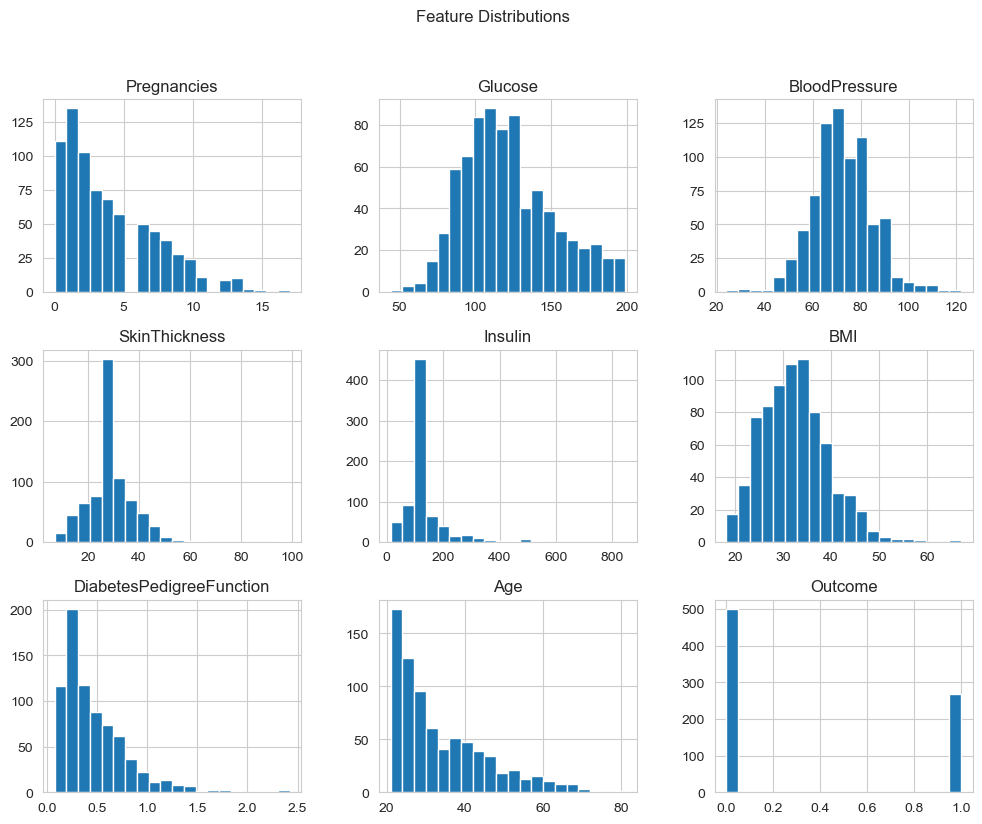

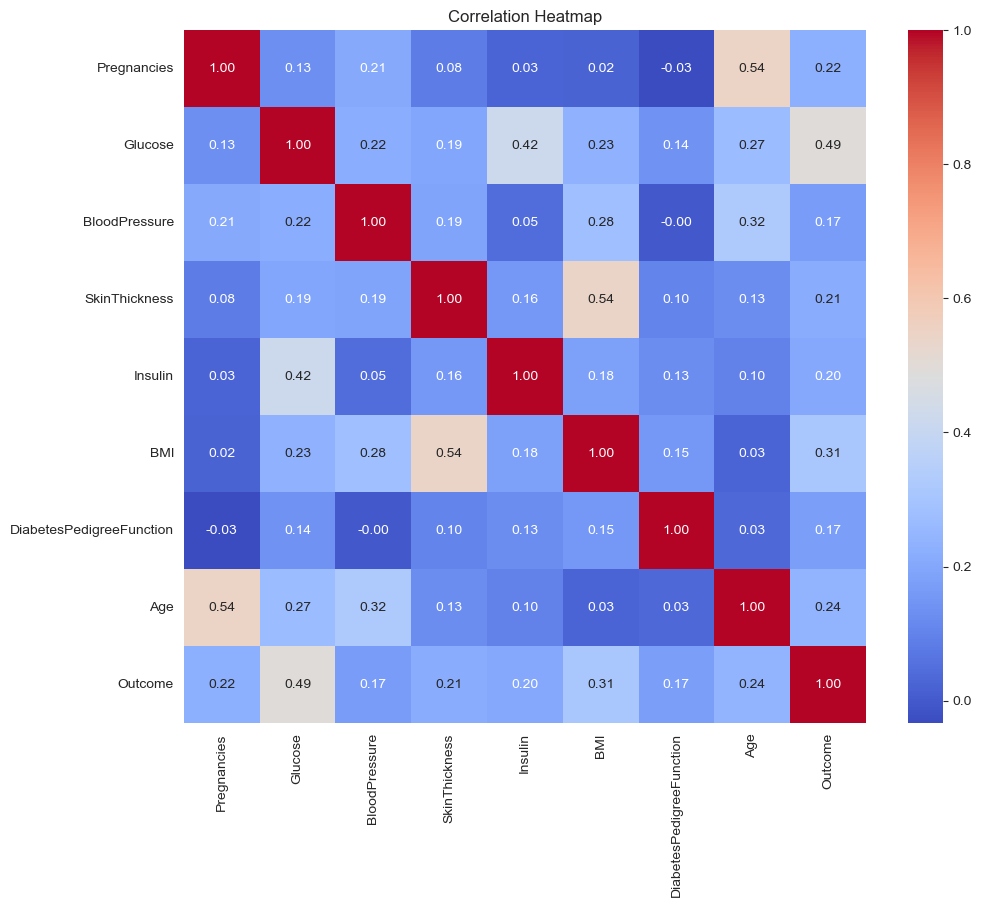

In [11]:
# Visualize the data
sns.set_style(style = "whitegrid")

# Histogram for each feature
df.hist(figsize=(12,9), bins = 20)
plt.suptitle("Feature Distributions")
plt.show()

# Correlation heatmap
plt.figure(figsize=(11,9))
sns.heatmap(df.corr(), annot = True, cmap = "coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [17]:
# Split data into training and testing sets
X = df.drop('Outcome', axis = 1)
y = df['Outcome']

In [18]:
# Pipeline + grid search for L1 regularization

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(penalty="l1", solver="liblinear", max_iter=2000, random_state=42))
])

# Search a range of C values (inverse regularization strength)
grid = {"clf__C": [0.001, 0.01, 0.1, 1, 10, 100]}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(pipe, grid, scoring="roc_auc", cv=cv, n_jobs=-1)
search.fit(X, y)

print("Best C:", search.best_params_["clf__C"])
print(f"Best mean ROC AUC: {search.best_score_:.3f}")

Best C: 0.1
Best mean ROC AUC: 0.838


In [22]:
# Hold-out evaluation of the best L1 model

# Train/test split (stratified for class balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Get the best estimator from the grid search
best_l1 = search.best_estimator_

# Fit on the training set
best_l1.fit(X_train, y_train)

# Predict on the test set
y_pred = best_l1.predict(X_test)
y_prob = best_l1.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"ROC AUC:   {auc:.3f}")

# Confusion matrix and classification report
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))

Accuracy:  0.708
Precision: 0.596
Recall:    0.519
F1-score:  0.554
ROC AUC:   0.807

Confusion Matrix:
 [[81 19]
 [26 28]]

Classification Report:
               precision    recall  f1-score   support

           0      0.757     0.810     0.783       100
           1      0.596     0.519     0.554        54

    accuracy                          0.708       154
   macro avg      0.676     0.664     0.669       154
weighted avg      0.700     0.708     0.703       154



In [21]:
# Inspect sparsity of L1 model
clf = best_l1.named_steps["clf"]
coef = clf.coef_[0]

coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": coef,
    "abs_coef": np.abs(coef)
}).sort_values("abs_coef", ascending=False)

print("Non-zero coefficients:", np.sum(coef != 0))
print("Zeroed-out coefficients:", np.sum(coef == 0))
coef_df

Non-zero coefficients: 5
Zeroed-out coefficients: 3


,feature,coef,abs_coef
1,Glucose,1.025221,1.025221
5,BMI,0.541895,0.541895
0,Pregnancies,0.271773,0.271773
6,DiabetesPedigreeFunction,0.128701,0.128701
7,Age,0.084047,0.084047
2,BloodPressure,0.000000,0.000000
3,SkinThickness,0.000000,0.000000
4,Insulin,0.000000,0.000000
